# 🎯 Parkinson's Disease Detection from Voice
## Domain Adaptation Pipeline

Implementación del paper "Towards a Corpus (and Language)-Independent Screening of Parkinson's Disease from Voice and Speech through Domain Adaptation"

### 📋 Pipeline:
1. **Setup**: Configuración del entorno (Colab/Local)
2. **Data Loading**: Carga de archivos de audio de vocales (.egg)
3. **Preprocessing**: Preprocesamiento según paper (44.1kHz, ventanas 400ms, Mel spectrograms 65×41)
4. **Dataset Creation**: Generación de tensores PyTorch listos para entrenamiento
5. **Visualization**: Análisis visual de señales y espectrogramas
6. **Training**: Entrenamiento de modelos CNN con domain adaptation
7. **Evaluation**: Evaluación del rendimiento

### ⚙️ Características:
- ✅ Preprocesamiento exacto del paper
- ✅ Modular y reutilizable (dataclasses, type hints)
- ✅ Reproducible (dominios determinísticos)
- ✅ Compatible: Local & Google Colab
- ✅ PyTorch-ready: Dataset wrapper incluido


In [1]:
# Instalación de dependencias (solo necesario en Colab)
import sys
import os

# Detectar si estamos en Colab
try:
    import google.colab
    IN_COLAB = True
    print("🚀 Ejecutando en Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Ejecutando localmente")

# Instalar dependencias si estamos en Colab
if IN_COLAB:
    %pip install librosa soundfile scikit-learn matplotlib seaborn pandas numpy
    %pip install torch torchvision torchaudio tqdm
    # Montar Google Drive si es necesario
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Asegúrate de tener instaladas las siguientes librerías:")
    print("- librosa, soundfile, scikit-learn")
    print("- matplotlib, seaborn, pandas, numpy")
    print("- torch, torchvision, torchaudio (FRAMEWORK PRINCIPAL)")
    print("- tqdm (para barras de progreso)")
    
    # Instalar tqdm si no está disponible
    try:
        from tqdm import tqdm
        print("✅ tqdm ya está instalado")
    except ImportError:
        print("⚠️ Instalando tqdm...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])
        from tqdm import tqdm
        print("✅ tqdm instalado correctamente")


💻 Ejecutando localmente
Asegúrate de tener instaladas las siguientes librerías:
- librosa, soundfile, scikit-learn
- matplotlib, seaborn, pandas, numpy
- torch, torchvision, torchaudio (FRAMEWORK PRINCIPAL)
- tqdm (para barras de progreso)
✅ tqdm ya está instalado


In [2]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path

# Agregar módulos al path
sys.path.insert(0, str(Path.cwd()))

# Importar MÓDULOS PROPIOS (código modular reutilizable)
from modules import preprocessing, augmentation, dataset, utils, visualization
from modules.preprocessing import (
    SAMPLE_RATE, WINDOW_MS, OVERLAP, N_MELS, HOP_MS,
    FFT_WINDOW, TARGET_FRAMES,
    get_preprocessing_config, print_preprocessing_config
)
from modules.dataset import (
    SampleMeta, VowelSegmentsDataset, build_full_pipeline
)
from modules.visualization import (
    visualize_audio_and_spectrograms,
    plot_label_distribution,
    plot_spectrogram_comparison
)

# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
import random
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reporte de configuración
print(f"✅ Librerías y módulos cargados correctamente")
print(f"🔧 Dispositivo: {device}")
print(f"📦 PyTorch: {torch.__version__}")
print(f"📦 Librosa: {librosa.__version__}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

# Mostrar configuración de preprocesamiento
print("\n" + "="*60)
print_preprocessing_config()
print("="*60)
print("\n📦 Módulos importados:")
print("   ✓ preprocessing  - Funciones de preprocesamiento")
print("   ✓ augmentation   - Técnicas de data augmentation")
print("   ✓ dataset        - Pipeline de dataset PyTorch")
print("   ✓ utils          - Utilidades comunes")
print("   ✓ visualization  - Gráficas y visualizaciones")


✅ Librerías y módulos cargados correctamente
🔧 Dispositivo: cpu
📦 PyTorch: 2.8.0+cpu
📦 Librosa: 0.11.0

⚙️ Preprocessing Configuration:
  • SAMPLE_RATE: 44100
  • WINDOW_MS: 400
  • OVERLAP: 0.5
  • N_MELS: 65
  • HOP_MS: 10
  • FFT_WINDOW: 40
  • TARGET_FRAMES: 41

📦 Módulos importados:
   ✓ preprocessing  - Funciones de preprocesamiento
   ✓ augmentation   - Técnicas de data augmentation
   ✓ dataset        - Pipeline de dataset PyTorch
   ✓ utils          - Utilidades comunes
   ✓ visualization  - Gráficas y visualizaciones


## 📁 1. Data Loading

Configuración de rutas y exploración del dataset de vocales.


In [3]:
# ============================================================
# CONFIGURACIÓN DE RUTAS - PARKINSON Y HEALTHY
# ============================================================

# Configuración de rutas
if IN_COLAB:
    DATA_PATH_PARKINSON = "/content/drive/MyDrive/parkinson-voice-uncertainty/data/vowels_pk"
    DATA_PATH_HEALTHY = "/content/drive/MyDrive/parkinson-voice-uncertainty/data/vowels_healthy"
else:
    DATA_PATH_PARKINSON = "./data/vowels_pk"
    DATA_PATH_HEALTHY = "./data/vowels_healthy"

# Extensión de archivos (usar .egg para ambos - consistencia)
AUDIO_EXTENSION = "egg"

print("="*70)
print("📁 CARGANDO DATASETS BALANCEADOS")
print("="*70)

# ============================================================
# DATASET PARKINSON
# ============================================================
print(f"\n🔴 PARKINSON:")
print(f"   Ruta: {DATA_PATH_PARKINSON}")

if os.path.exists(DATA_PATH_PARKINSON):
    audio_files_pk = list(Path(DATA_PATH_PARKINSON).glob(f"*.{AUDIO_EXTENSION}"))
    print(f"   ✅ {len(audio_files_pk)} archivos .{AUDIO_EXTENSION}")
    if audio_files_pk:
        print(f"   📝 Ejemplos: {', '.join([f.name for f in audio_files_pk[:3]])}")
else:
    print(f"   ❌ No se encontró el directorio")
    audio_files_pk = []

# ============================================================
# DATASET HEALTHY
# ============================================================
print(f"\n🟢 HEALTHY:")
print(f"   Ruta: {DATA_PATH_HEALTHY}")

if os.path.exists(DATA_PATH_HEALTHY):
    audio_files_hl = list(Path(DATA_PATH_HEALTHY).glob(f"*.{AUDIO_EXTENSION}"))
    print(f"   ✅ {len(audio_files_hl)} archivos .{AUDIO_EXTENSION}")
    if audio_files_hl:
        print(f"   📝 Ejemplos: {', '.join([f.name for f in audio_files_hl[:3]])}")
else:
    print(f"   ❌ No se encontró el directorio")
    audio_files_hl = []

# ============================================================
# VERIFICACIÓN DE BALANCE
# ============================================================
print(f"\n" + "="*70)
print(f"📊 BALANCE DE DATOS:")
print(f"   Parkinson: {len(audio_files_pk)} archivos")
print(f"   Healthy:   {len(audio_files_hl)} archivos")
if audio_files_pk and audio_files_hl:
    balance_pct = len(audio_files_pk) / len(audio_files_hl) * 100
    print(f"   Ratio: {balance_pct:.1f}%")
    if len(audio_files_pk) == len(audio_files_hl):
        print(f"   ✅ BALANCE PERFECTO (1:1)")
print("="*70)


📁 CARGANDO DATASETS BALANCEADOS

🔴 PARKINSON:
   Ruta: ./data/vowels_pk
   ✅ 13 archivos .egg
   📝 Ejemplos: 1580-a_h-egg.egg, 1580-a_l-egg.egg, 1580-a_lhl-egg.egg

🟢 HEALTHY:
   Ruta: ./data/vowels_healthy
   ✅ 13 archivos .egg
   📝 Ejemplos: 1022-a_lhl-egg.egg, 103-u_n-egg.egg, 1121-u_h-egg.egg

📊 BALANCE DE DATOS:
   Parkinson: 13 archivos
   Healthy:   13 archivos
   Ratio: 100.0%
   ✅ BALANCE PERFECTO (1:1)


## 🎵 2. Audio Preprocessing

Configuración de preprocesamiento (módulo `modules/preprocessing.py`):
- **Resampling**: 44.1 kHz
- **Segmentation**: Ventanas de 400ms con 50% overlap
- **Mel Spectrograms**: 65 bandas Mel, hop 10ms
- **FFT Windows**: 40ms para todas las vocales sostenidas
- **Target Shape**: 65 × 41 (freq × time)
- **Normalization**: z-score


## 3. Dataset Generation - Flujo de Trabajo

Este notebook ofrece **dos opciones** para generar el dataset:

### Opción A: Dataset Exploratorio (Celda siguiente)
- ⚡ **Rápido**: ~30 segundos
- 📊 **Propósito**: Exploración y visualización rápida
- 🔍 **Útil para**: Ver datos, debugging, testing inicial
- ⚠️ **Opcional**: Si vas a usar augmentation, puedes saltar esta celda

### Opción B: Dataset con Augmentation (Celda 14)
- 🎯 **Completo**: Dataset listo para entrenamiento
- 💾 **Con cache**: Primera vez ~7 min, luego < 5 seg
- ✅ **Incluye**: Versiones "original" + augmentadas
- 🚀 **Recomendado**: Para training final

---

### 💡 Recomendación

**Primera vez:** Ejecuta ambas (explorar + entrenar)  
**Re-ejecuciones:** Salta directo a Celda 14  
**Solo explorar:** Ejecuta solo la siguiente celda

---


In [4]:
# ============================================================
# DATASET PIPELINE → modules/dataset.py
# ============================================================
# Procesamiento BASE (sin augmentation) para ambos datasets
# Reutiliza el mismo pipeline para Parkinson y Healthy

print("="*70)
print("📦 EJECUTANDO PIPELINE DESDE modules/dataset.py")
print("="*70)

# ============================================================
# 1. PROCESAR PARKINSON
# ============================================================
print("\n🔴 PROCESANDO DATASET PARKINSON...")
print("="*60)

try:
    results_pk = build_full_pipeline(
        audio_files=audio_files_pk,
        preprocess_fn=None,  # Usa preprocessing.preprocess_audio_paper
        max_files=None
    )
    
    # Extraer resultados
    dataset_pk = results_pk["dataset"]
    (X_pk, y_task_pk, y_domain_pk) = results_pk["tensors"]
    
    print(f"\n✅ Parkinson procesado:")
    print(f"   • Muestras: {len(dataset_pk)}")
    print(f"   • Shape: {X_pk.shape if X_pk is not None else 'None'}")
    print(f"   • Dominios: {len(torch.unique(y_domain_pk))}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    dataset_pk = []
    X_pk = y_task_pk = y_domain_pk = None

# ============================================================
# 2. PROCESAR HEALTHY
# ============================================================
print("\n🟢 PROCESANDO DATASET HEALTHY...")
print("="*60)

try:
    results_hl = build_full_pipeline(
        audio_files=audio_files_hl,
        preprocess_fn=None,  # Mismo pipeline
        max_files=None
    )
    
    # Extraer resultados
    dataset_hl = results_hl["dataset"]
    (X_hl, y_task_hl, y_domain_hl) = results_hl["tensors"]
    
    print(f"\n✅ Healthy procesado:")
    print(f"   • Muestras: {len(dataset_hl)}")
    print(f"   • Shape: {X_hl.shape if X_hl is not None else 'None'}")
    print(f"   • Dominios: {len(torch.unique(y_domain_hl))}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    dataset_hl = []
    X_hl = y_task_hl = y_domain_hl = None

# ============================================================
# 3. RESUMEN
# ============================================================
print("\n" + "="*70)
print("📊 RESUMEN DE PROCESAMIENTO BASE:")
print("="*70)
if X_pk is not None and X_hl is not None:
    print(f"🔴 Parkinson: {X_pk.shape[0]} espectrogramas | Shape: {tuple(X_pk.shape[1:])}")
    print(f"🟢 Healthy:   {X_hl.shape[0]} espectrogramas | Shape: {tuple(X_hl.shape[1:])}")
    print(f"\n💡 Siguiente paso: Aplicar augmentation para multiplicar datos")
print("="*70)


📦 EJECUTANDO PIPELINE DESDE modules/dataset.py

🔴 PROCESANDO DATASET PARKINSON...
🔄 Procesando 13 archivos...
  1/13: 1580-a_h-egg.egg
  11/13: 1580-u_l-egg.egg
✅ 121 muestras generadas
📊 PyTorch tensors listos:
  - X: (121, 1, 65, 41)
  - y_task: (121,)  (dist={0: 121})
  - y_domain: (121,)  (K dominios=13)

📊 DISTRIBUCIÓN POR VOCAL:
  - a_h: 1 muestras
  - a_l: 2 muestras
  - a_lhl: 3 muestras
  - a_n: 2 muestras
  - iau: 97 muestras
  - i_h: 2 muestras
  - i_l: 2 muestras
  - i_lhl: 3 muestras
  - i_n: 3 muestras
  - u_h: 1 muestras
  - u_l: 1 muestras
  - u_lhl: 3 muestras
  - u_n: 1 muestras

📊 DISTRIBUCIÓN POR CONDICIÓN:
  - egg: 121 muestras

✅ Dataset COMPLETO listo para entrenamiento con PyTorch!
  - Muestras totales: 121
  - Dimensiones de entrada: (121, 1, 65, 41)
  - Ideal para CNN 2D

✅ Parkinson procesado:
   • Muestras: 121
   • Shape: torch.Size([121, 1, 65, 41])
   • Dominios: 13

🟢 PROCESANDO DATASET HEALTHY...
🔄 Procesando 13 archivos...
  1/13: 1022-a_lhl-egg.egg
  

In [5]:
# ============================================================
# VERIFICACIÓN DE DATASETS
# ============================================================

print("="*70)
print("🔍 VERIFICACIÓN DE DATASETS PROCESADOS")
print("="*70)

# Verificar Parkinson
if X_pk is not None:
    N, C, H, W = X_pk.shape
    print(f"\n🔴 PARKINSON:")
    print(f"   • Shape: {N} × {C} × {H} × {W}")
    print(f"   • Dominios únicos: {len(torch.unique(y_domain_pk))}")
    print(f"   • Label (task): {torch.unique(y_task_pk).tolist()}")
else:
    print("\n🔴 PARKINSON: ⚠️ No procesado")

# Verificar Healthy
if X_hl is not None:
    N, C, H, W = X_hl.shape
    print(f"\n🟢 HEALTHY:")
    print(f"   • Shape: {N} × {C} × {H} × {W}")
    print(f"   • Dominios únicos: {len(torch.unique(y_domain_hl))}")
    print(f"   • Label (task): {torch.unique(y_task_hl).tolist()}")
else:
    print("\n🟢 HEALTHY: ⚠️ No procesado")

# Balance
if X_pk is not None and X_hl is not None:
    print(f"\n📊 BALANCE:")
    print(f"   • Ratio: {X_pk.shape[0]} : {X_hl.shape[0]}")
    if X_pk.shape[0] == X_hl.shape[0]:
        print(f"   ✅ Datasets balanceados")
    else:
        print(f"   ⚠️ Datasets desbalanceados")

print("="*70)


🔍 VERIFICACIÓN DE DATASETS PROCESADOS

🔴 PARKINSON:
   • Shape: 121 × 1 × 65 × 41
   • Dominios únicos: 13
   • Label (task): [0]

🟢 HEALTHY:
   • Shape: 155 × 1 × 65 × 41
   • Dominios únicos: 13
   • Label (task): [0]

📊 BALANCE:
   • Ratio: 121 : 155
   ⚠️ Datasets desbalanceados


📦 VISUALIZACIÓN DE DATASETS PROCESADOS

🔴 VISUALIZANDO MUESTRAS DE PARKINSON:


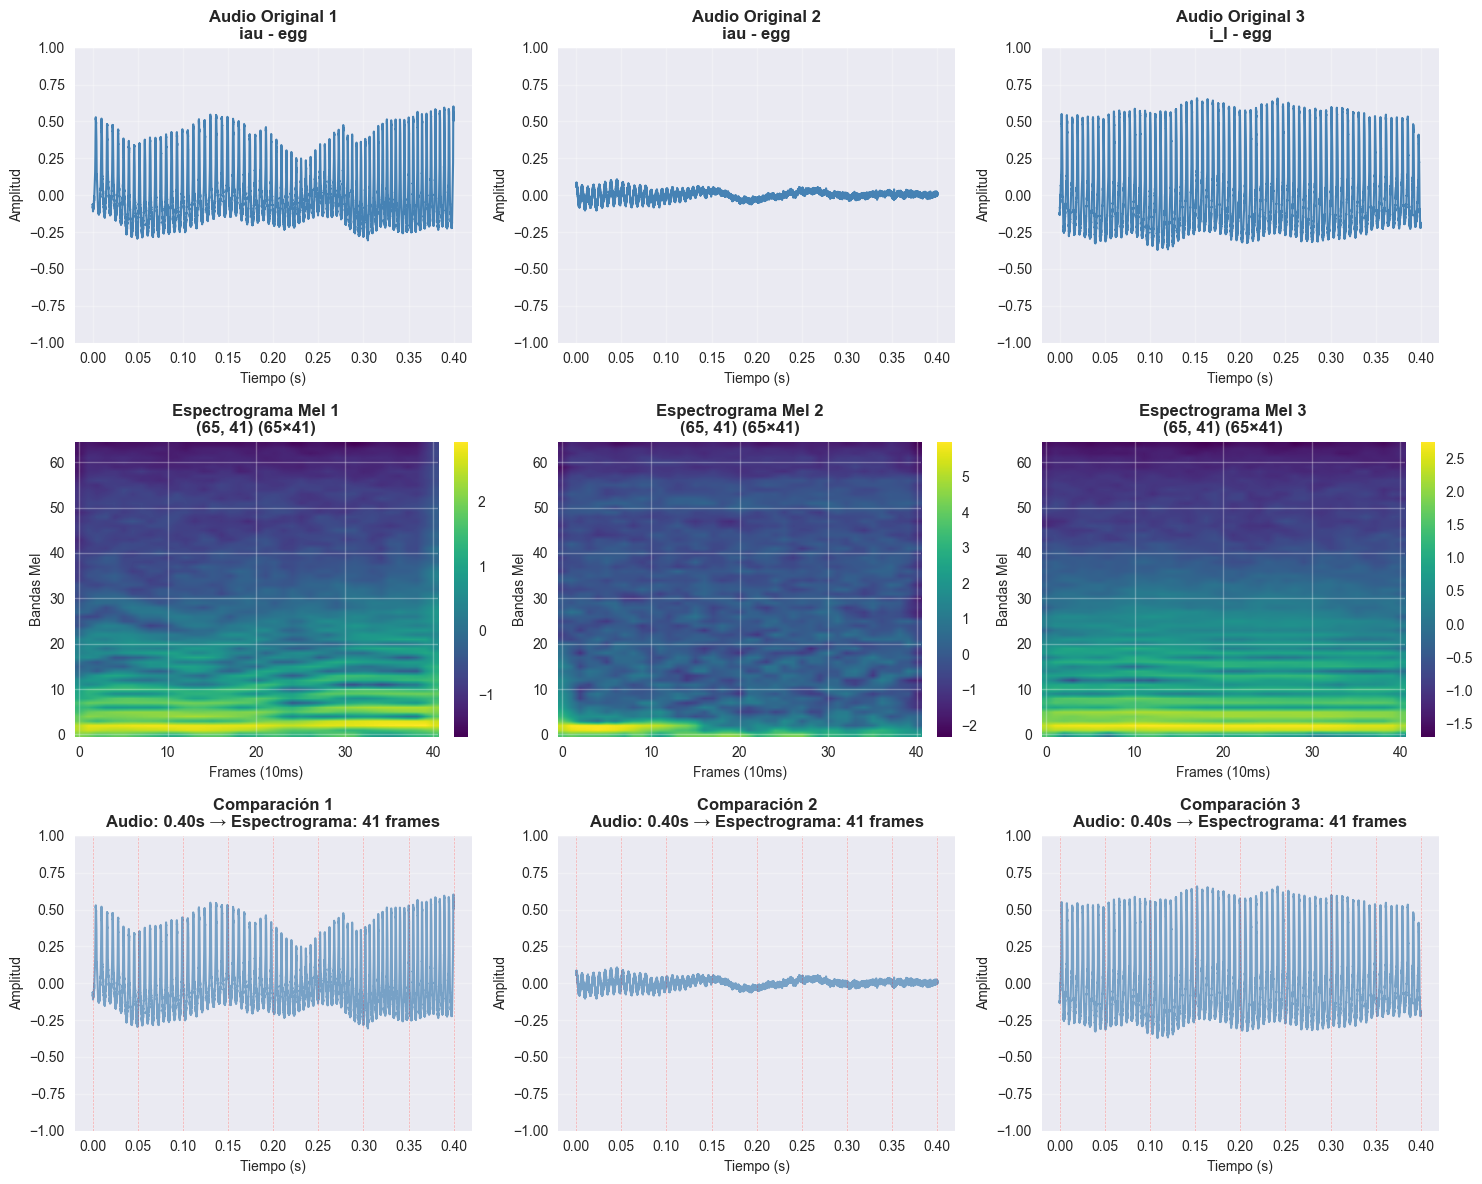


📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal i_l
  - Normalización: z-score aplicada
✅ Visualización Parkinson completada

🟢 VISUALIZANDO MUESTRAS DE HEALTHY:


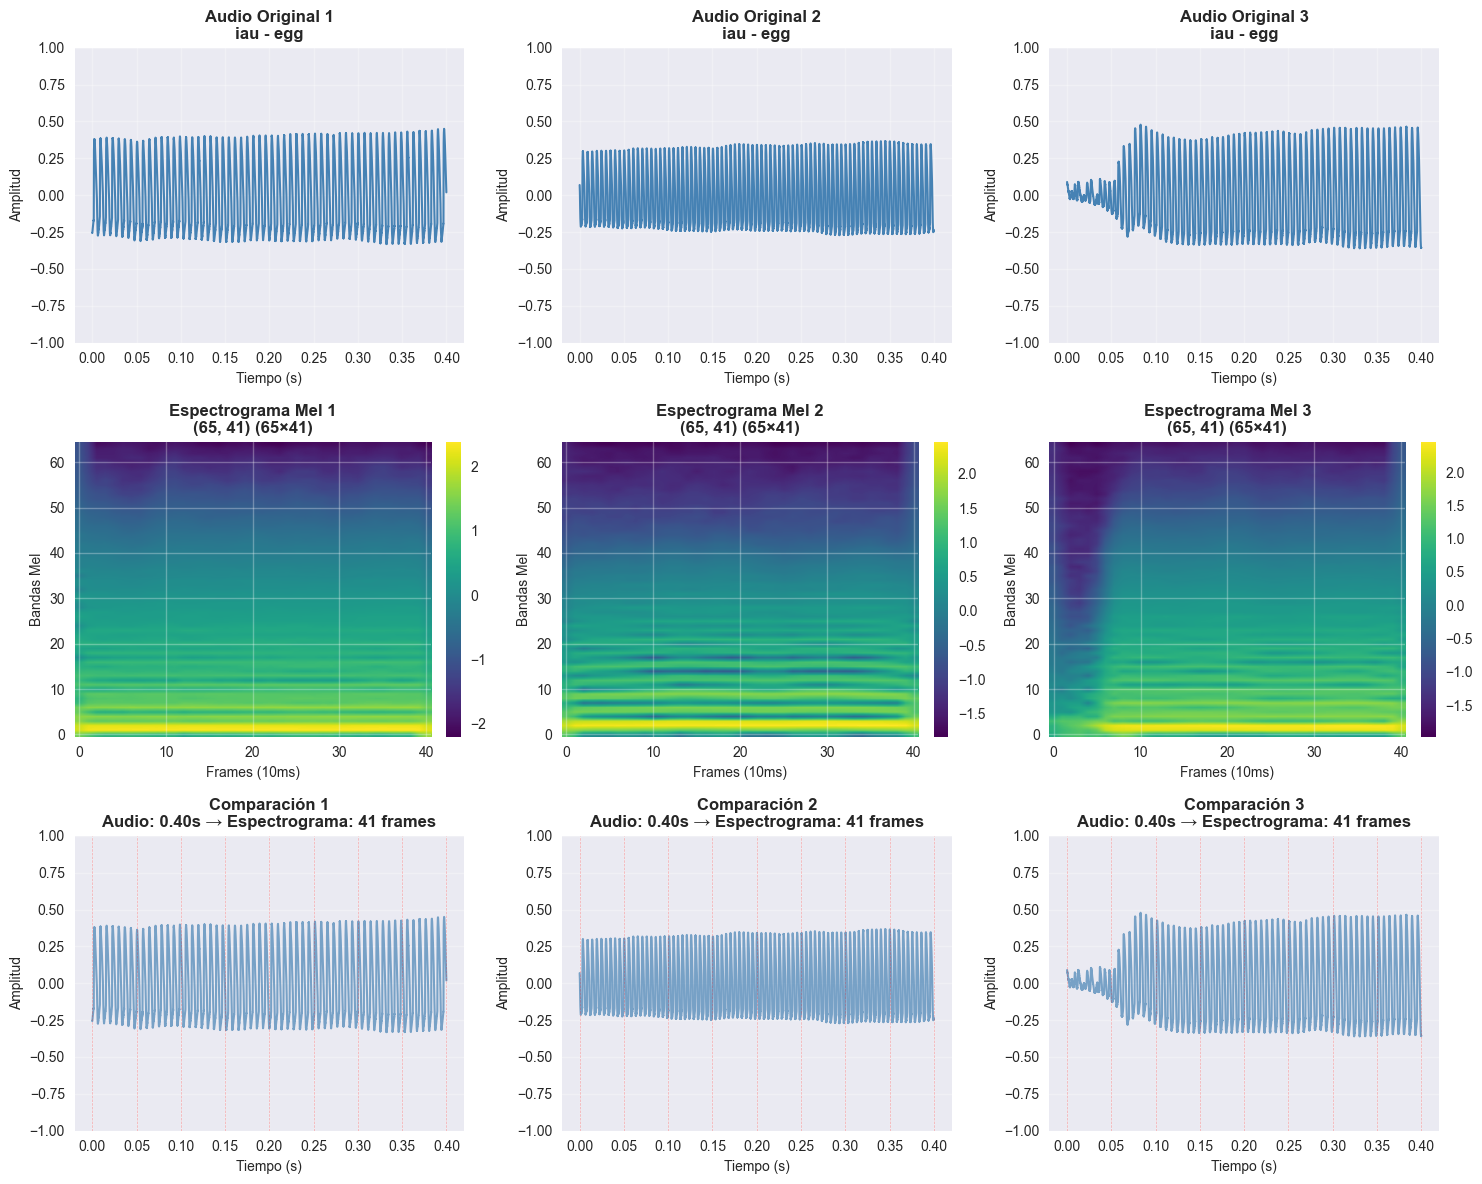


📊 INFORMACIÓN DEL PROCESAMIENTO:
  - Audio original: 0.40s (400ms por segmento)
  - Espectrograma: 65×41 (65 bandas × 41 frames)
  - Frames temporales: 41 (cada 10ms)
  - Ventana FFT: 25ms para vocal iau
  - Normalización: z-score aplicada
✅ Visualización Healthy completada

💡 Variables generadas: fig_pk, audios_pk, fig_hl, audios_hl


In [6]:
# ============================================================
# VISUALIZACIÓN → modules/visualization.py
# ============================================================

print("="*70)
print("📦 VISUALIZACIÓN DE DATASETS PROCESADOS")
print("="*70)

# Visualizar muestras de Parkinson
if dataset_pk and len(dataset_pk) > 0:
    print("\n🔴 VISUALIZANDO MUESTRAS DE PARKINSON:")
    print("="*60)
    
    fig_pk, audios_pk = visualize_audio_and_spectrograms(
        dataset_pk,
        num_samples=3,
        sr=SAMPLE_RATE,
        show=True,
        play_audio=False  # Evitar reproducir muchos audios
    )
    
    print("✅ Visualización Parkinson completada")
else:
    print("\n🔴 PARKINSON: ⚠️ No hay datos para visualizar")

# Visualizar muestras de Healthy
if dataset_hl and len(dataset_hl) > 0:
    print("\n🟢 VISUALIZANDO MUESTRAS DE HEALTHY:")
    print("="*60)
    
    fig_hl, audios_hl = visualize_audio_and_spectrograms(
        dataset_hl,
        num_samples=3,
        sr=SAMPLE_RATE,
        show=True,
        play_audio=False
    )
    
    print("✅ Visualización Healthy completada")
else:
    print("\n🟢 HEALTHY: ⚠️ No hay datos para visualizar")

print("\n" + "="*70)
print("💡 Variables generadas: fig_pk, audios_pk, fig_hl, audios_hl")
print("="*70)


In [7]:
# ============================================================
# DATA AUGMENTATION - LAS 3 TÉCNICAS (OPTIMIZADO)
# ============================================================
from modules.augmentation import preprocess_audio_with_augmentation
from modules.dataset import parse_filename

print("🎵 DATA AUGMENTATION - LAS 3 TÉCNICAS")
print("="*60)
print("Pipeline: Audio completo → Augment → Segment → Mel → Normalize\n")

# Archivo de ejemplo (usar Parkinson)
if audio_files_pk:
    example_file = audio_files_pk[0]
    subject_id, vowel_type, condition = parse_filename(example_file.stem)
    print(f"🎯 Archivo: {example_file.name} | Vocal: {vowel_type} | Condición: {condition}\n")
else:
    print("⚠️ No hay archivos disponibles")
    example_file = None

# Configuración de augmentations (elimina duplicación)
AUG_DEMOS = {
    "original": {
        "title": "AUDIO ORIGINAL",
        "params_list": [(None, "")],
        "lib": ""
    },
    "pitch_shift": {
        "title": "PITCH SHIFTING (cambiar tono)",
        "params_list": [
            ({"n_steps": n}, f"{n:+2d} semitonos {'↑' if n > 0 else '↓'}") 
            for n in [-2, -1, 1, 2]
        ],
        "lib": "librosa.effects.pitch_shift(y, sr, n_steps=±2)"
    },
    "time_stretch": {
        "title": "TIME STRETCHING (cambiar velocidad)",
        "params_list": [
            ({"rate": r}, f"{r:.1f}x {'rápido' if r > 1.0 else 'lento'}") 
            for r in [0.9, 1.1]
        ],
        "lib": "librosa.effects.time_stretch(y, rate=1.1)"
    },
    "noise": {
        "title": "RUIDO ADITIVO (≈30 dB SNR)",
        "params_list": [({"noise_factor": 0.005}, "0.005")],
        "lib": "y + 0.005 * np.random.randn(len(y))"
    }
}

# Aplicar todas las augmentations (loop unificado)
results = {}

if example_file:
    for idx, (aug_type, config) in enumerate(AUG_DEMOS.items(), 1):
        print(f"📌 {idx}. {config['title']}")
        if config['lib']:
            print(f"   {config['lib']}")
        
        results[aug_type] = {}
        for params, desc in config['params_list']:
            specs, segs, label = preprocess_audio_with_augmentation(
                example_file, vowel_type=vowel_type,
                aug_type=aug_type, aug_params=params
            )
            results[aug_type][str(params or '')] = {
                "specs": specs, "segs": segs, "label": label
            }
            print(f"   ✓ {desc or 'sin augment'}: {len(segs)} segs → '{label}'")
        print()
    
    # Resumen compacto
    total = sum(len(v) for v in results.values())
    num_files = len(audio_files_pk) if audio_files_pk else 0
    print(f"✅ RESUMEN: {total} versiones | {num_files} archivos × {total} = {num_files * total} total")
    print(f"💡 Variables: results['pitch_shift'], results['time_stretch'], results['noise'], results['original']")
else:
    print("⚠️ No se puede ejecutar demo sin archivos")


🎵 DATA AUGMENTATION - LAS 3 TÉCNICAS
Pipeline: Audio completo → Augment → Segment → Mel → Normalize

🎯 Archivo: 1580-a_h-egg.egg | Vocal: a_h | Condición: egg

📌 1. AUDIO ORIGINAL
   ✓ sin augment: 1 segs → 'original'

📌 2. PITCH SHIFTING (cambiar tono)
   librosa.effects.pitch_shift(y, sr, n_steps=±2)
   ✓ -2 semitonos ↓: 1 segs → 'pitch_-2'
   ✓ -1 semitonos ↓: 1 segs → 'pitch_-1'
   ✓ +1 semitonos ↑: 1 segs → 'pitch_+1'
   ✓ +2 semitonos ↑: 1 segs → 'pitch_+2'

📌 3. TIME STRETCHING (cambiar velocidad)
   librosa.effects.time_stretch(y, rate=1.1)
   ✓ 0.9x lento: 2 segs → 'time_0.90x'
   ✓ 1.1x rápido: 1 segs → 'time_1.10x'

📌 4. RUIDO ADITIVO (≈30 dB SNR)
   y + 0.005 * np.random.randn(len(y))
   ✓ 0.005: 1 segs → 'noise_0.0050'

✅ RESUMEN: 8 versiones | 13 archivos × 8 = 104 total
💡 Variables: results['pitch_shift'], results['time_stretch'], results['noise'], results['original']


✨ SPECAUGMENT - Máscaras de Frecuencia y Tiempo
Diferencia: Audio augment → ANTES de segmentar | SpecAugment → DESPUÉS de Mel

📌 SIN SpecAugment: 1 specs → 'original'
📌 CON SpecAugment: 1 specs → 'spec_aug'
📌 Pitch+SpecAugment: 1 specs → 'pitch_+2_spec_aug'


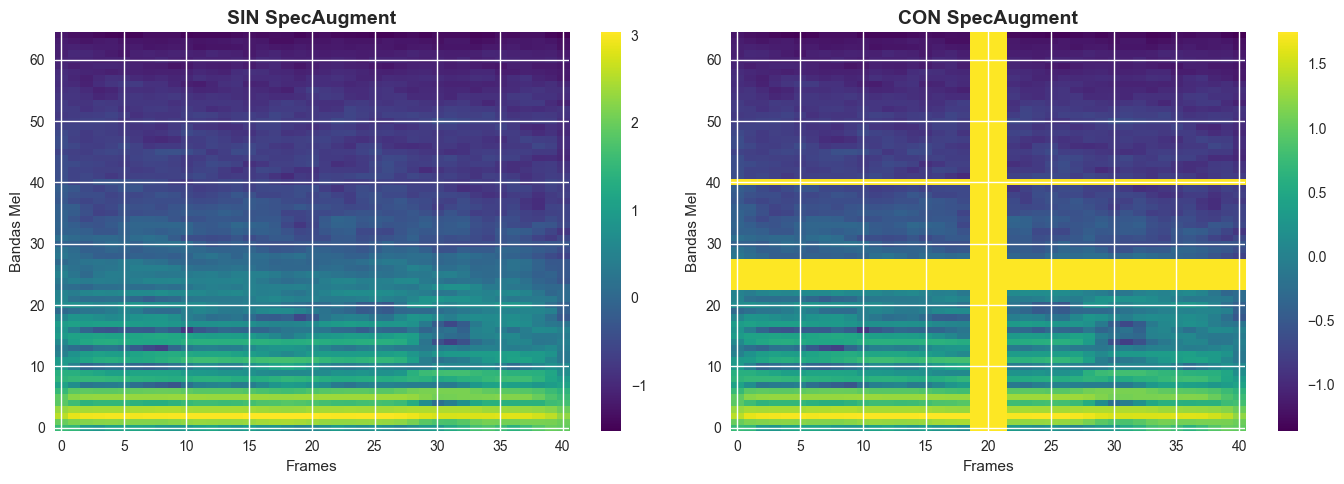


💡 Observa las máscaras (regiones oscuras) en el espectrograma derecho


In [8]:
# ============================================================
# SPECAUGMENT - AUGMENTATION SOBRE ESPECTROGRAMA (OPTIMIZADO)
# ============================================================
import matplotlib.pyplot as plt

print("✨ SPECAUGMENT - Máscaras de Frecuencia y Tiempo")
print("="*60)
print("Diferencia: Audio augment → ANTES de segmentar | SpecAugment → DESPUÉS de Mel\n")

# Configuración SpecAugment
SPEC_AUG_PARAMS = {"freq_mask_param": 10, "time_mask_param": 5, 
                   "num_freq_masks": 2, "num_time_masks": 2}

# Comparación: SIN vs CON SpecAugment
configs = [
    ("SIN SpecAugment", False, None),
    ("CON SpecAugment", True, SPEC_AUG_PARAMS),
    ("Pitch+SpecAugment", True, SPEC_AUG_PARAMS)  # Combinado
]

specs_comparison = {}

if example_file:
    for title, apply_spec, params in configs:
        aug_type = "pitch_shift" if "Pitch" in title else "original"
        aug_params = {"n_steps": 2} if "Pitch" in title else None
        
        specs, segs, label = preprocess_audio_with_augmentation(
            example_file, vowel_type=vowel_type,
            aug_type=aug_type, aug_params=aug_params,
            apply_spec_augment=apply_spec, spec_augment_params=params
        )
        specs_comparison[title] = (specs, label)
        print(f"📌 {title}: {len(specs)} specs → '{label}'")

    # Visualización compacta (primeros 2)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    titles = list(specs_comparison.keys())[:2]

    for idx, (ax, title) in enumerate(zip(axes, titles)):
        spec = specs_comparison[title][0][0]
        im = ax.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Frames'); ax.set_ylabel('Bandas Mel')
        plt.colorbar(im, ax=ax)

    plt.tight_layout(); plt.show()
    print("\n💡 Observa las máscaras (regiones oscuras) en el espectrograma derecho")
else:
    print("⚠️ No se puede ejecutar demo de SpecAugment sin archivos")


In [9]:
# ============================================================
# AUGMENTATION PARA AMBOS DATASETS
# ============================================================
from modules.augmentation import create_augmented_dataset
from modules.dataset import to_pytorch_tensors
import pandas as pd
from collections import Counter

print("="*70)
print("🎨 APLICANDO AUGMENTATION A AMBOS DATASETS")
print("="*70)

# ============================================================
# CONFIGURACIÓN DE AUGMENTATION
# ============================================================
APPLY_AUGMENTATION = True
APPLY_SPEC_AUGMENT = True

# Técnicas de augmentation
AUGMENTATION_TYPES = ["original", "pitch_shift", "time_stretch", "noise"]
NUM_SPEC_AUGMENT_VERSIONS = 2

# Cache separado para cada dataset
USE_CACHE = True
FORCE_REGENERATE = False

if IN_COLAB:
    CACHE_DIR_PK = "/content/drive/MyDrive/parkinson-cache/parkinson"
    CACHE_DIR_HL = "/content/drive/MyDrive/parkinson-cache/healthy"
else:
    CACHE_DIR_PK = "./cache/parkinson"
    CACHE_DIR_HL = "./cache/healthy"

print(f"\n⚙️  CONFIGURACIÓN:")
print(f"   • Augmentation: {'✅' if APPLY_AUGMENTATION else '❌'}")
print(f"   • Técnicas: {', '.join(AUGMENTATION_TYPES)}")
print(f"   • SpecAugment: {NUM_SPEC_AUGMENT_VERSIONS}x versiones")
print(f"   • Cache: {'✅' if USE_CACHE else '❌'}")

# ============================================================
# 1. AUGMENTATION PARKINSON
# ============================================================
print(f"\n🔴 AUGMENTANDO PARKINSON...")
print("="*60)

if APPLY_AUGMENTATION and audio_files_pk:
    augmented_dataset_pk = create_augmented_dataset(
        audio_files_pk,
        augmentation_types=AUGMENTATION_TYPES,
        apply_spec_augment=APPLY_SPEC_AUGMENT,
        num_spec_augment_versions=NUM_SPEC_AUGMENT_VERSIONS,
        progress_every=3,
        use_cache=USE_CACHE,
        cache_dir=CACHE_DIR_PK,
        force_regenerate=FORCE_REGENERATE
    )
    X_aug_pk, y_task_aug_pk, y_domain_aug_pk, meta_aug_pk = to_pytorch_tensors(augmented_dataset_pk)
    
    print(f"\n✅ Parkinson augmentado:")
    print(f"   • Original: {len(audio_files_pk)} archivos")
    print(f"   • Augmentado: {len(augmented_dataset_pk)} muestras")
    print(f"   • Factor: {len(augmented_dataset_pk)/len(audio_files_pk):.1f}x")
    print(f"   • Shape: {X_aug_pk.shape}")
else:
    print("⚠️ Skipped")
    augmented_dataset_pk = []
    X_aug_pk = y_task_aug_pk = y_domain_aug_pk = meta_aug_pk = None

# ============================================================
# 2. AUGMENTATION HEALTHY
# ============================================================
print(f"\n🟢 AUGMENTANDO HEALTHY...")
print("="*60)

if APPLY_AUGMENTATION and audio_files_hl:
    augmented_dataset_hl = create_augmented_dataset(
        audio_files_hl,
        augmentation_types=AUGMENTATION_TYPES,
        apply_spec_augment=APPLY_SPEC_AUGMENT,
        num_spec_augment_versions=NUM_SPEC_AUGMENT_VERSIONS,
        progress_every=3,
        use_cache=USE_CACHE,
        cache_dir=CACHE_DIR_HL,
        force_regenerate=FORCE_REGENERATE
    )
    X_aug_hl, y_task_aug_hl, y_domain_aug_hl, meta_aug_hl = to_pytorch_tensors(augmented_dataset_hl)
    
    print(f"\n✅ Healthy augmentado:")
    print(f"   • Original: {len(audio_files_hl)} archivos")
    print(f"   • Augmentado: {len(augmented_dataset_hl)} muestras")
    print(f"   • Factor: {len(augmented_dataset_hl)/len(audio_files_hl):.1f}x")
    print(f"   • Shape: {X_aug_hl.shape}")
else:
    print("⚠️ Skipped")
    augmented_dataset_hl = []
    X_aug_hl = y_task_aug_hl = y_domain_aug_hl = meta_aug_hl = None

# ============================================================
# 3. RESUMEN
# ============================================================
print("\n" + "="*70)
print("📊 RESUMEN DE AUGMENTATION:")
print("="*70)

if X_aug_pk is not None and X_aug_hl is not None:
    print(f"\n🔴 Parkinson: {X_aug_pk.shape[0]} espectrogramas")
    print(f"🟢 Healthy:   {X_aug_hl.shape[0]} espectrogramas")
    print(f"\n📊 Balance: {X_aug_pk.shape[0]} : {X_aug_hl.shape[0]}")
    if X_aug_pk.shape[0] == X_aug_hl.shape[0]:
        print("✅ PERFECTO BALANCE")
    print(f"\n💡 Siguiente: Combinar datasets para entrenamiento")
print("="*70)


🎨 APLICANDO AUGMENTATION A AMBOS DATASETS

⚙️  CONFIGURACIÓN:
   • Augmentation: ✅
   • Técnicas: original, pitch_shift, time_stretch, noise
   • SpecAugment: 2x versiones
   • Cache: ✅

🔴 AUGMENTANDO PARKINSON...
💾 Cargando dataset desde cache...
   📁 ./cache/parkinson\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1219 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1219, 1, 65, 41)
  - y_task: (1219,)  (dist={0: 1219})
  - y_domain: (1219,)  (K dominios=13)

✅ Parkinson augmentado:
   • Original: 13 archivos
   • Augmentado: 1219 muestras
   • Factor: 93.8x
   • Shape: torch.Size([1219, 1, 65, 41])

🟢 AUGMENTANDO HEALTHY...
💾 Cargando dataset desde cache...
   📁 ./cache/healthy\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1553 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1553, 1, 65, 41)
  - y_task: (1553,)  (dist={0: 1553})
  - y_domain: (1553,)  (K dominios=13)

✅ Healthy augmentado:
   • Original: 13 a

In [10]:
# ============================================================
# COMBINAR DATASETS PARA ENTRENAMIENTO
# ============================================================

print("="*70)
print("🔗 COMBINANDO PARKINSON + HEALTHY")
print("="*70)

if X_aug_pk is not None and X_aug_hl is not None:
    # Combinar espectrogramas
    X_combined = torch.cat([X_aug_pk, X_aug_hl], dim=0)
    
    # Crear labels: 1=Parkinson, 0=Healthy
    y_task_combined = torch.cat([
        torch.ones(len(X_aug_pk)),    # Parkinson = 1
        torch.zeros(len(X_aug_hl))    # Healthy = 0
    ], dim=0)
    
    # Combinar domains (ajustar IDs para evitar colisiones)
    max_domain_pk = y_domain_aug_pk.max().item()
    y_domain_combined = torch.cat([
        y_domain_aug_pk,
        y_domain_aug_hl + max_domain_pk + 1  # Offset para healthy
    ], dim=0)
    
    print(f"\n📊 DATASET COMBINADO:")
    print(f"   • Total muestras: {len(X_combined)}")
    print(f"   • Shape: {X_combined.shape}")
    print(f"   • Parkinson: {(y_task_combined == 1).sum().item()}")
    print(f"   • Healthy: {(y_task_combined == 0).sum().item()}")
    print(f"   • Dominios únicos: {len(torch.unique(y_domain_combined))}")
    
    balance_pct = (y_task_combined == 1).sum() / len(y_task_combined) * 100
    print(f"   • Balance: {balance_pct:.1f}% Parkinson / {100-balance_pct:.1f}% Healthy")
    
    if abs(balance_pct - 50) < 5:
        print(f"   ✅ BALANCE EXCELENTE")
    
    print(f"\n💡 Variables generadas:")
    print(f"   • X_combined: {X_combined.shape}")
    print(f"   • y_task_combined: {y_task_combined.shape}")
    print(f"   • y_domain_combined: {y_domain_combined.shape}")
else:
    print("⚠️ Faltan datos augmentados")
    X_combined = y_task_combined = y_domain_combined = None

print("="*70)


🔗 COMBINANDO PARKINSON + HEALTHY

📊 DATASET COMBINADO:
   • Total muestras: 2772
   • Shape: torch.Size([2772, 1, 65, 41])
   • Parkinson: 1219
   • Healthy: 1553
   • Dominios únicos: 26
   • Balance: 44.0% Parkinson / 56.0% Healthy

💡 Variables generadas:
   • X_combined: torch.Size([2772, 1, 65, 41])
   • y_task_combined: torch.Size([2772])
   • y_domain_combined: torch.Size([2772])


## 🧠 4. Red Neuronal CNN con Domain Adaptation

Pipeline de entrenamiento según Ibarra et al. (2023):
- **Arquitectura dual-head**: Clasificador PD + Clasificador de Dominio con GRL
- **Gradient Reversal Layer**: Hace features invariantes al dominio
- **Loss multi-task**: `loss = loss_pd + α * loss_domain`
- **Lambda scheduling**: Factor GRL aumenta progresivamente


In [11]:
# ============================================================
# PREPARACIÓN DE DATOS PARA ENTRENAMIENTO
# ============================================================
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

print("="*70)
print("📊 PREPARACIÓN DE DATOS PARA CNN")
print("="*70)

# Verificar datos combinados
if X_combined is not None:
    print(f"\n✅ Datos combinados disponibles:")
    print(f"   • X_combined: {X_combined.shape}")
    print(f"   • y_task_combined: {y_task_combined.shape}")
    print(f"   • y_domain_combined: {y_domain_combined.shape}")
    
    # Split train/val/test (70/15/15)
    X_train_val, X_test, y_task_train_val, y_task_test, y_domain_train_val, y_domain_test = train_test_split(
        X_combined, y_task_combined, y_domain_combined,
        test_size=0.15, random_state=42, stratify=y_task_combined
    )
    
    X_train, X_val, y_task_train, y_task_val, y_domain_train, y_domain_val = train_test_split(
        X_train_val, y_task_train_val, y_domain_train_val,
        test_size=0.176,  # 0.176 * 0.85 ≈ 0.15 del total
        random_state=42, stratify=y_task_train_val
    )
    
    print(f"\n📊 SPLITS:")
    print(f"   • Train: {X_train.shape[0]} ({X_train.shape[0]/len(X_combined)*100:.1f}%)")
    print(f"   • Val:   {X_val.shape[0]} ({X_val.shape[0]/len(X_combined)*100:.1f}%)")
    print(f"   • Test:  {X_test.shape[0]} ({X_test.shape[0]/len(X_combined)*100:.1f}%)")
    
    # Convertir labels a Long para CrossEntropyLoss
    y_task_train = y_task_train.long()
    y_task_val = y_task_val.long()
    y_task_test = y_task_test.long()
    y_domain_train = y_domain_train.long()
    y_domain_val = y_domain_val.long()
    y_domain_test = y_domain_test.long()
    
    # Crear DataLoaders
    train_dataset = TensorDataset(X_train, y_task_train, y_domain_train)
    val_dataset = TensorDataset(X_val, y_task_val, y_domain_val)
    test_dataset = TensorDataset(X_test, y_task_test, y_domain_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    print(f"\n✅ DataLoaders creados:")
    print(f"   • Train batches: {len(train_loader)}")
    print(f"   • Val batches:   {len(val_loader)}")
    print(f"   • Test batches:  {len(test_loader)}")
    
else:
    print("\n⚠️ No hay datos combinados. Ejecuta las celdas anteriores primero.")

print("="*70)


📊 PREPARACIÓN DE DATOS PARA CNN

✅ Datos combinados disponibles:
   • X_combined: torch.Size([2772, 1, 65, 41])
   • y_task_combined: torch.Size([2772])
   • y_domain_combined: torch.Size([2772])

📊 SPLITS:
   • Train: 1941 (70.0%)
   • Val:   415 (15.0%)
   • Test:  416 (15.0%)

✅ DataLoaders creados:
   • Train batches: 61
   • Val batches:   7
   • Test batches:  7


🏗️  CREANDO MODELO CNN2D con Domain Adaptation

📊 Configuración:
   • Dominios únicos: 26
   • Clases PD: 2 (HC/PD)
   • Input shape: (B, 1, 65, 41)

✅ Modelo creado en device: cpu

🏗️  ARQUITECTURA DEL MODELO
CNN2D_DA(
  (feature_extractor): FeatureExtractor(
    (block1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
  )
  (pd_head): Class

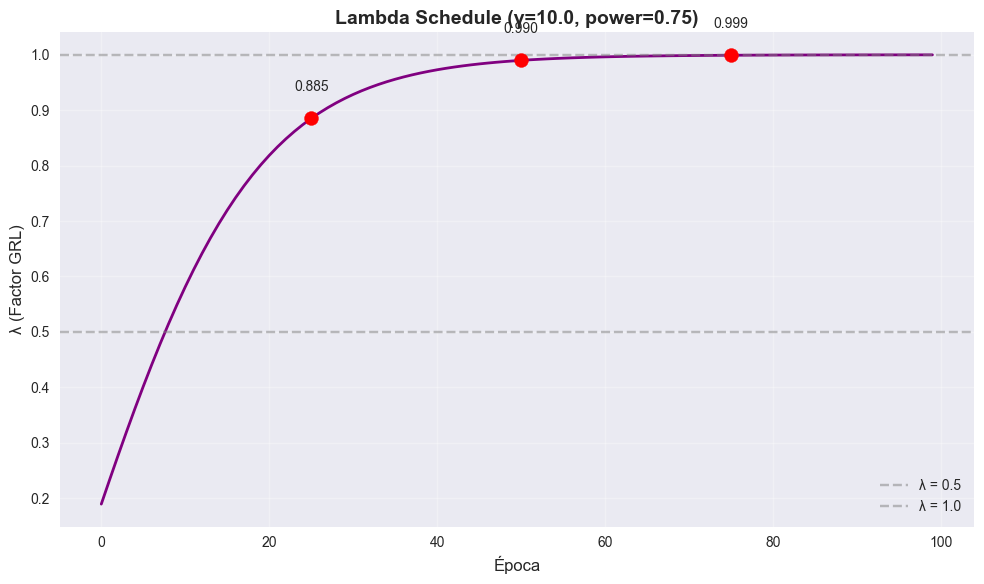

In [12]:
# ============================================================
# CREAR MODELO CNN con DOMAIN ADAPTATION
# ============================================================
from modules.cnn_model import CNN2D_DA
from modules.cnn_utils import print_model_architecture, plot_lambda_schedule

print("="*70)
print("🏗️  CREANDO MODELO CNN2D con Domain Adaptation")
print("="*70)

# Número de dominios únicos
n_domains = len(torch.unique(y_domain_combined))
print(f"\n📊 Configuración:")
print(f"   • Dominios únicos: {n_domains}")
print(f"   • Clases PD: 2 (HC/PD)")
print(f"   • Input shape: (B, 1, 65, 41)")

# Crear modelo
model_da = CNN2D_DA(
    n_domains=n_domains,
    p_drop_conv=0.3,
    p_drop_fc=0.5
).to(device)

print(f"\n✅ Modelo creado en device: {device}")

# Imprimir arquitectura
print_model_architecture(model_da, input_shape=(1, 1, 65, 41))

# Test forward pass
print("\n" + "="*70)
print("🧪 TEST FORWARD PASS")
print("="*70)

x_test = torch.randn(4, 1, 65, 41).to(device)
logits_pd, logits_domain = model_da(x_test)

print(f"Input shape: {x_test.shape}")
print(f"Output PD shape: {logits_pd.shape} → Binario (HC/PD)")
print(f"Output Domain shape: {logits_domain.shape} → {n_domains} dominios")
print(f"✅ Forward pass exitoso!")

# Visualizar lambda schedule
print("\n📊 Visualizando Lambda Schedule...")
fig = plot_lambda_schedule(n_epochs=100, gamma=10.0, power=0.75, show=True)

print("="*70)


In [13]:
# ============================================================
# ENTRENAMIENTO CON DOMAIN ADAPTATION (IBARRA 2023)
# ============================================================
from modules.cnn_training import train_model_da
from modules.cnn_utils import compute_class_weights_auto
from pathlib import Path

print("="*70)
print("🚀 ENTRENAMIENTO CNN2D con DOMAIN ADAPTATION (IBARRA 2023)")
print("="*70)

# Configuración según paper
N_EPOCHS = 100
ALPHA = 1.0  # Peso de loss_domain
EARLY_STOPPING_PATIENCE = 15
LEARNING_RATE = 0.1  # LR inicial 0.1 según Ibarra 2023
LAMBDA_CONSTANT = 1.0  # Lambda constante (sin schedule)

# Calcular pesos automáticos para train set
print("\n📊 CALCULANDO CLASS WEIGHTS AUTOMÁTICOS:")
print("   PD (tarea principal):")
pd_weights = compute_class_weights_auto(y_task_train, threshold=0.4)

print("   Dominio (tarea auxiliar):")
domain_weights = compute_class_weights_auto(y_domain_train, threshold=0.4)

# Crear criterios con pesos si hay desbalance
if pd_weights is not None:
    criterion_pd = nn.CrossEntropyLoss(weight=pd_weights.to(device))
else:
    criterion_pd = nn.CrossEntropyLoss()

if domain_weights is not None:
    criterion_domain = nn.CrossEntropyLoss(weight=domain_weights.to(device))
else:
    criterion_domain = nn.CrossEntropyLoss()

# Optimizador SGD con LR 0.1 (Ibarra 2023)
optimizer = torch.optim.SGD(
    model_da.parameters(),
    lr=LEARNING_RATE,
    momentum=0.9,
    weight_decay=1e-4
)

# LR Scheduler: StepLR (decay cada 30 épocas)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=30,  # Decay cada 30 épocas
    gamma=0.1      # Multiplicar LR por 0.1
)

# Lambda scheduler CONSTANTE (Ibarra 2023)
lambda_scheduler = lambda epoch: LAMBDA_CONSTANT

# Directorio para checkpoints
save_dir = Path("./results/cnn_da")

print(f"\n⚙️  CONFIGURACIÓN SEGÚN IBARRA (2023):")
print(f"   • Épocas máximas: {N_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE} (SGD)")
print(f"   • LR Scheduler: StepLR (step=30, gamma=0.1)")
print(f"   • Lambda GRL: {LAMBDA_CONSTANT} (constante)")
print(f"   • Alpha (peso dominio): {ALPHA}")
print(f"   • Early stopping: {EARLY_STOPPING_PATIENCE} épocas")
print(f"   • Optimizer: SGD (momentum=0.9, weight_decay=1e-4)")
print(f"   • Class weights: Automáticos (detecta desbalance)")
print(f"   • Save dir: {save_dir}")

# Entrenar
print("\n" + "="*70)
print("INICIANDO ENTRENAMIENTO...")
print("="*70 + "\n")

results_da = train_model_da(
    model=model_da,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion_pd=criterion_pd,
    criterion_domain=criterion_domain,
    device=device,
    n_epochs=N_EPOCHS,
    alpha=ALPHA,
    lambda_scheduler=lambda_scheduler,
    lr_scheduler=lr_scheduler,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    save_dir=save_dir,
    verbose=True
)

print("\n✅ Entrenamiento completado!")
print(f"   • Tiempo total: {results_da['total_time']/60:.1f} minutos")
print(f"   • Mejor val_loss_pd: {results_da['best_val_loss_pd']:.4f}")

# Guardar historial
history_da = results_da["history"]
print(f"\n💾 Variables guardadas: results_da, history_da")


🚀 ENTRENAMIENTO CNN2D con DOMAIN ADAPTATION (IBARRA 2023)

📊 CALCULANDO CLASS WEIGHTS AUTOMÁTICOS:
   PD (tarea principal):
   ✓ Dataset balanceado (min class: 44.0%). Sin pesos.
   Dominio (tarea auxiliar):
   ⚠️  Desbalance detectado (min class: 0.3%). Aplicando pesos.

⚙️  CONFIGURACIÓN SEGÚN IBARRA (2023):
   • Épocas máximas: 100
   • Learning rate: 0.1 (SGD)
   • LR Scheduler: StepLR (step=30, gamma=0.1)
   • Lambda GRL: 1.0 (constante)
   • Alpha (peso dominio): 1.0
   • Early stopping: 15 épocas
   • Optimizer: SGD (momentum=0.9, weight_decay=1e-4)
   • Class weights: Automáticos (detecta desbalance)
   • Save dir: results\cnn_da

INICIANDO ENTRENAMIENTO...


INICIO DE ENTRENAMIENTO CON DOMAIN ADAPTATION
Épocas máximas: 100
Early stopping patience: 15
Alpha (peso dominio): 1.0
Device: cpu

Época   1/100 | λ=1.000 | Train: L_PD=2.0693 L_Dom=7.9843 | Val: L_PD=0.6861 F1=0.0000 | 7.4s
Época   2/100 | λ=1.000 | Train: L_PD=0.6901 L_Dom=3.3006 | Val: L_PD=0.6862 F1=0.0000 | 6.8s
Épo

📊 VISUALIZACIÓN DEL ENTRENAMIENTO
💾 Gráfica guardada en: results\cnn_da\training_progress.png


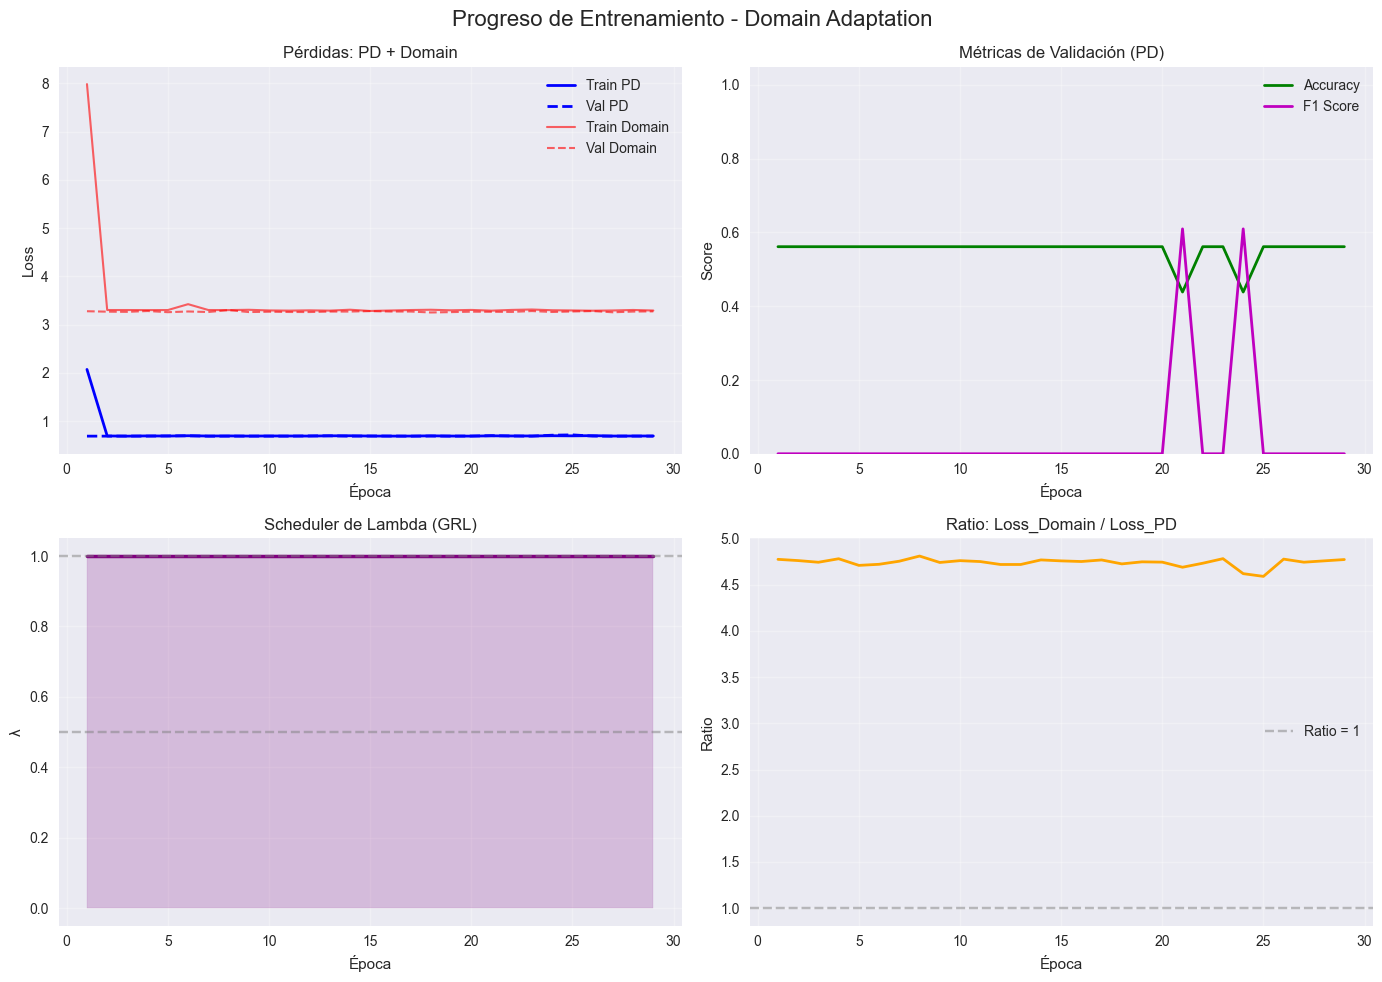


✅ Gráficas guardadas en: results\cnn_da


In [14]:
# ============================================================
# VISUALIZACIÓN DEL ENTRENAMIENTO
# ============================================================
from modules.cnn_visualization import plot_da_training_progress

print("="*70)
print("📊 VISUALIZACIÓN DEL ENTRENAMIENTO")
print("="*70)

# Graficar progreso
fig = plot_da_training_progress(
    history_da,
    save_path=save_dir / "training_progress.png",
    show=True
)

print(f"\n✅ Gráficas guardadas en: {save_dir}")
print("="*70)


🎯 EVALUACIÓN EN TEST SET

📊 MÉTRICAS EN TEST:
   • Loss PD: 0.6862
   • Loss Domain: 3.3258
   • Loss Total: 4.0120
   • Accuracy PD: 0.5601
   • F1 PD: 0.0000
   • Precision PD: 0.0000
   • Recall PD: 0.0000
   • Accuracy Domain: 0.0072

📊 MATRIZ DE CONFUSIÓN:
              Pred HC  Pred PD
Real HC           233        0
Real PD           183        0

📈 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

          HC     0.5601    1.0000    0.7180       233
          PD     0.0000    0.0000    0.0000       183

    accuracy                         0.5601       416
   macro avg     0.2800    0.5000    0.3590       416
weighted avg     0.3137    0.5601    0.4022       416

💾 Matriz guardada en: results\cnn_da\confusion_matrix_test.png


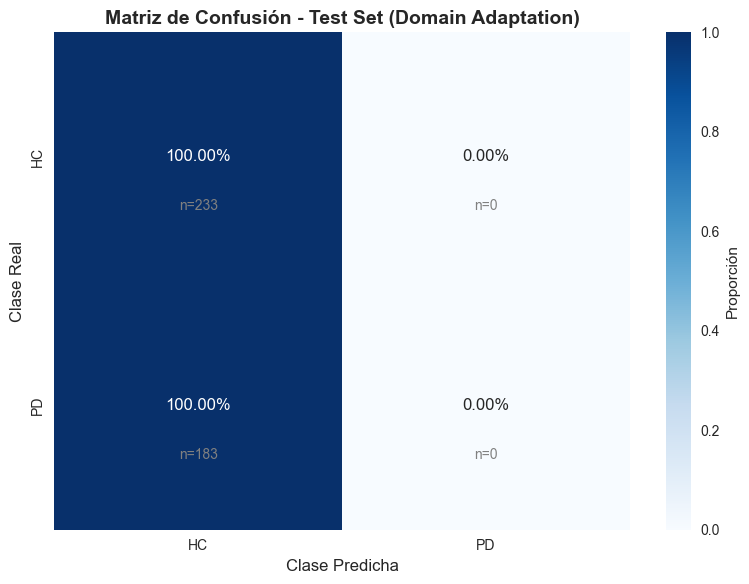


✅ Evaluación completada!


In [15]:
# ============================================================
# EVALUACIÓN EN TEST SET
# ============================================================
from modules.cnn_training import evaluate_da
from modules.cnn_utils import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

print("="*70)
print("🎯 EVALUACIÓN EN TEST SET")
print("="*70)

# Evaluar modelo DA
test_metrics = evaluate_da(
    model=model_da,
    loader=test_loader,
    criterion_pd=criterion_pd,
    criterion_domain=criterion_domain,
    device=device,
    alpha=ALPHA
)

print(f"\n📊 MÉTRICAS EN TEST:")
print(f"   • Loss PD: {test_metrics['loss_pd']:.4f}")
print(f"   • Loss Domain: {test_metrics['loss_domain']:.4f}")
print(f"   • Loss Total: {test_metrics['loss_total']:.4f}")
print(f"   • Accuracy PD: {test_metrics['acc_pd']:.4f}")
print(f"   • F1 PD: {test_metrics['f1_pd']:.4f}")
print(f"   • Precision PD: {test_metrics['precision_pd']:.4f}")
print(f"   • Recall PD: {test_metrics['recall_pd']:.4f}")
print(f"   • Accuracy Domain: {test_metrics['acc_domain']:.4f}")

# Obtener predicciones para matriz de confusión
model_da.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        specs, labels_pd, _ = batch
        specs = specs.to(device)
        
        logits_pd, _ = model_da(specs)
        preds = logits_pd.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_pd.numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print(f"\n📊 MATRIZ DE CONFUSIÓN:")
print(f"              Pred HC  Pred PD")
print(f"Real HC       {cm[0, 0]:7d}  {cm[0, 1]:7d}")
print(f"Real PD       {cm[1, 0]:7d}  {cm[1, 1]:7d}")

# Reporte de clasificación
report = classification_report(
    all_labels, all_preds,
    target_names=["HC", "PD"],
    digits=4
)
print(f"\n📈 REPORTE DE CLASIFICACIÓN:")
print(report)

# Visualizar matriz de confusión
fig_cm = plot_confusion_matrix(
    cm,
    class_names=["HC", "PD"],
    title="Matriz de Confusión - Test Set (Domain Adaptation)",
    save_path=save_dir / "confusion_matrix_test.png",
    show=True
)

print(f"\n✅ Evaluación completada!")
print("="*70)


## 📋 Resumen y Cumplimiento del Paper

### ✅ Completado según Ibarra et al. (2023):
1. **Preprocesamiento**: Espectrogramas Mel 65×41, 44.1kHz, ventanas 400ms con 50% solape, z-score
2. **Data Augmentation**: Pitch shift, time stretch, noise, SpecAugment
3. **Arquitectura DA**: CNN2D con GRL, dual-head (PD + Domain), MaxPool 3×3
4. **Optimizador**: SGD con LR inicial 0.1, momentum 0.9, weight decay 1e-4
5. **LR Scheduler**: StepLR (decay cada 30 épocas, gamma=0.1)
6. **Cross-Entropy Ponderada**: Detección automática de desbalance en PD y dominio
7. **Lambda GRL**: Constante = 1.0 (según interpretación del paper)
8. **Evaluación**: Métricas completas (accuracy, precision, recall, F1)

### 🚀 Para Validación Cruzada Completa:
**Usar script `train_cnn_da_kfold.py`** para 10-fold CV estratificada independiente por hablante:
```bash
python train_cnn_da_kfold.py --hc_dir data/vowels_healthy --pd_dir data/vowels_pk
```

### 🎯 Próximos Pasos (Opcionales):
1. **Evaluación por Paciente**: Agregar probabilidades por `subject_id`
2. **MC Dropout**: Cuantificación de incertidumbre epistémica
3. **Grad-CAM**: Explicabilidad visual de predicciones
4. **Transfer Learning**: Pre-entrenar en SVDD + freeze primera capa conv
5. **Búsqueda de Hiperparámetros**: Implementar Talos con espacio del paper

### 📊 Configuración Actual (Ibarra 2023):
- **Arquitectura**: CNN2D-DA con MaxPool 3×3
- **Optimizador**: SGD (LR=0.1)
- **Scheduler**: StepLR activo
- **GRL Lambda**: Constante = 1.0
- **Class Weights**: Automáticos
- **Multi-task Loss**: L = L_PD + α·L_Domain
- **Validación**: Train/val/test o usar script 10-fold
